# CNN and LRP
## Preparation
For this project we will use PyTorch to create our CNN. For the LRP we will create our own package, specialised for the net we have created.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from lrp.lrp import LRPModel
from PIL import Image

In this code we prepare the dataset for training in multiple steps:
* Images are adjusted with transformations (resize, greyscale, normalisation) and then transformed to tensors because the images are very different due to being a large sample of MRIs.
* We choose a large training size (80%) for training but let 20% for training, with the amount of images we have, this should suffice.
* We then split them randomly and give the images labels first for training and later to know if the CNN was right with his prediction.

In [2]:
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize the images
    transforms.Grayscale(num_output_channels=1), # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Load the dataset from the folders
dataset = ImageFolder(root='./brain-tumor-data-set', transform=transform)

train_size = int(0.8 * len(dataset)) # 80% for training 
test_size = len(dataset) - train_size  # The rest for testing

# Create subsets
trainset, testset = random_split(dataset, [train_size, test_size])

# Create data loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define the class names (labels)
classes = ('Brain Tumor', 'Healthy')

Here is visualized a batch of training data with their labels. We do this to check the data quality and label distribution.

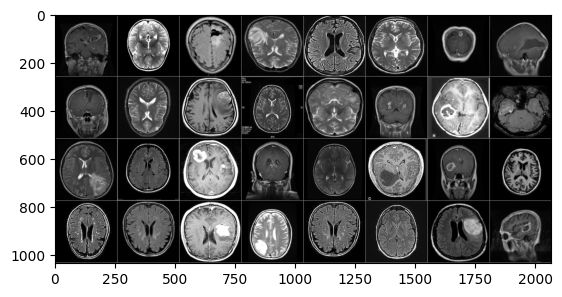

Brain Tumor Healthy Brain Tumor Brain Tumor Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Healthy Brain Tumor Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Brain Tumor Healthy Brain Tumor Brain Tumor Healthy Brain Tumor Brain Tumor Healthy Healthy Healthy Brain Tumor Brain Tumor Healthy Healthy Brain Tumor Brain Tumor


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and print labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Now we can define our CNN. For this we choose two Convolutional Layers (conv1, conv2) and three Fully Connected Layers (fc1, fc2, fc3). The architecture uses ReLU activation functions and is designed to process input images (1 channel, greyscale) and classify them into two classes (Brain Tumour, Healthy).

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.relu1 = nn.ReLU() 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(20 * 248 * 248, 50)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 2) # 2 Classes (Brain Tumor / Healthy)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()

## Training
Now we can train our net. For the training process we will use several epochs. In each epoch, the data is processed by the model in batches. The loss is calculated (``criterion``), a backpropagation step is performed and the model parameters are updated (``optimiser.step()``). The loss function is CrossEntropyLoss, which is suitable for classification problems. The optimiser SGD (Stochastic Gradient Descent) updates the model parameters with a learning rate of 0.01 and momentum of 0.9 in order to converge faster and more stably. Once completed, the training phase ends.

In [ ]:
num_epochs = 5  # Number of epochs to train
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    net.train()  # Set the model to training mode
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Zero the parameter gradients after each batch
        optimizer.zero_grad()
        
        # Forward pass
        outputs = net(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

print('Finished Training')

We now save our trained CNN parameters in the ``cifar_net.pth`` file so that we can reload the parameters later without having to retrain the model.

In [19]:
PATH = './saved-net/cifar_net.pth'
torch.save(net.state_dict(), PATH)

Here we can load the previously saved model (``cifar_net.pth``) into the newly created model net.

In [20]:
PATH = './saved-net/cifar_net.pth'
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

## Verification
This code visualises a batch of test images and outputs the associated ground truth labels. This is used to check which classes are contained in the test data batch and what the images look like so that the model can be validated later.

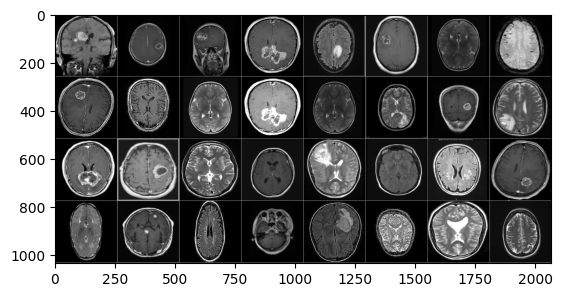

GroundTruth:  Brain Tumor Brain Tumor Brain Tumor Brain Tumor


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Here we evaluate the accuracy of the model on the test dataset. During inference, gradient computation is disabled (``torch.no_grad()``) to reduce memory usage. For each test image, the prediction is made and the number of correct predictions is compared to the number of ``predicted == labels``. Finally, the overall accuracy of the model on the test data is calculated and output.

In [22]:
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = net(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 94 %


Now we can calculate the accuracy of the model for each individual class. For each test batch, it checks whether the prediction of the model matches the actual class, and the correct predictions for each class are counted. At the end, the exact accuracy for each class is calculated and output to see how well the model performs for each specific class.

In [23]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Brain Tumor is 91.8 %
Accuracy for class: Healthy is 96.9 %


## First observation
We can see that the model is usually more accurate at identifying a brain with a tumor than a healthy brain. This may be due to the fact that the CNN may incorrectly identify healthy parts of the brain as a brain tumor. To show you this, here are two images, one with a brain tumor and one without, guess which one!

![differences](images-documentation/differences.png "Differences")

Answer: The left one has a brain tumour, the right one is healthy.

Now we will run an LRP on our CNN to see how the choice might be made and what patterns helped to make that choice.

## LRP
This code implements the LRP application on an image to visualise the most important features for model prediction. The LRP is performed in three steps:

* ``load_LRP()``: Loads the trained model and prepares it for LRP.
* ``run_LRP()``: Applies LRP to an image to calculate the relevance map. First, the image is prepared with the necessary transformations (grayscale, resize, normalisation) and then run through the LRP model.
* ``create_relevance_map()``: Unnormalises the input image and visualises both the original image and the calculated relevance map. The latter shows which parts of the image have influenced the model's decision the most.

At the end, a relevance map is created and visualised for a selected image, showing the contribution of each pixel to the classification of the image.

### Select which image to analyse
With ``SELECTED_IMAGE`` you can select an image by entering an integer (up to about 2080). Not all integers will work because the selected dataset skips some numbers.\
``HAS_BRAIN_TUMOR`` can be set to ``True`` to analyse an image with a brain tumor and ``False`` to analyse an image with a healthy brain.

### Interesting cases to try
- Brain tumor: 101, 257, 1000, 1001, 1003, 1005, 1007, 1022, 1023, 1029, 1034, 2025, 2026, 2035, 2036
- Healthy: 4, 6

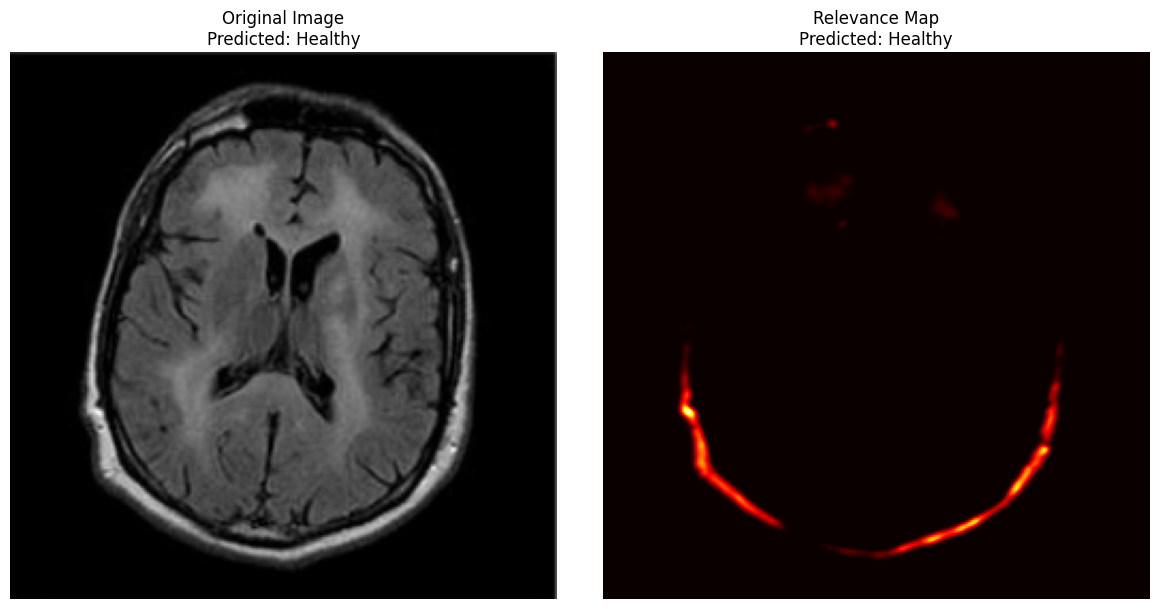

In [18]:
SELECTED_IMAGE: int = 101
HAS_BRAIN_TUMOR: bool = False

def load_LRP() -> LRPModel:
    net = Net()
    net.load_state_dict(torch.load(PATH, weights_only=True))
    return LRPModel(net)

def run_LRP(lrp_model, image) -> (torch.Tensor, str):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    input_tensor = transform(image).unsqueeze(0)  # Preprocess input image
    outputs = net(input_tensor)  # Get model predictions
    _, predicted_class = torch.max(outputs, 1)  # Find predicted class
    predicted_label = classes[predicted_class.item()]  # Convert to class name
    relevance_map = lrp_model.forward(input_tensor)  # Generate relevance map

    return relevance_map, predicted_label

def create_relevance_map(relevance_map, image, predicted_label) -> None:
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    input_image_np = transform(image).detach().numpy()
    input_image_np = input_image_np.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    input_image_np = (input_image_np * 0.5 + 0.5)  # Unnormalize to [0, 1]

    relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(input_image_np)
    axes[0].set_title(f"Original Image\nPredicted: {predicted_label}")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(relevance_map, cmap='hot')
    axes[1].set_title(f"Relevance Map\nPredicted: {predicted_label}")
    axes[1].axis('off')  # Hide axes

    fig.tight_layout()
    plt.show()

if(HAS_BRAIN_TUMOR):
    image = Image.open(f"./brain-tumor-data-set/Brain-Tumor/Cancer ({SELECTED_IMAGE}).jpg")
else:
    image = Image.open(f"./brain-tumor-data-set/Healthy/Not Cancer  ({SELECTED_IMAGE}).jpg")

lrp_model = load_LRP()
relevance_map, predicted_label = run_LRP(lrp_model, image)
create_relevance_map(relevance_map, image, predicted_label)

## Conclusion

### Observation
#### Reconzing Brain Tumor
It is common for parts of the eye to be mistaken for tumors.
The MRI machine uses a large magnet and a computer to take pictures of the inside of your body. Each picture, or 'slice', shows only a few layers of body tissue at a time. [[5]](https://stanfordhealthcare.org/medical-tests/m/mri.html) This means that there are MRIs where the eye is in the slice taken and sometimes it is not. This means that in most training data there are no eyes, and these can be misinterpreted as tumors. Here is an example:\
![eyes seen as brain tumor](images-documentation/eyes_brain_tumor.png "Eyes Seen As Brain Tumor")

In this case the prediction was correct by chance, he misinterpreted the eye as a brain tumor, but didn't recognise the real brain tumor.

This also shows that the CNN seems to have difficulty finding small brain tumors, as seen above. This may be due to the fact that there isn't a lot of training data of these small tumors, because most of the time the early stages aren't caught, because at the moment there are no brain cancer screening methods that can be used to accurately detect a brain tumor before a person starts experiencing symptoms. [12]

But for larger brain tumors, the CNN can see the difference between a healthy brain and one with a tumor, as shown in the next image, where we can clearly see the brain tumor in the heatmap:\
![brain tumor 2](images-documentation/brain_tumor_2.png "Brain Tumor 2")

#### Reconzing Healthy Brain
There appear to be two methods used by the CNN to detect a healthy brain:
1. Recognise the border of the brain with no abnormalities in the brain\
![reconize healthy brain 1](images-documentation/reconize_h_1.png "Reconize Healthy Brain 1")

2. Recognise the entire brain structure\
![reconize healthy brain 2](images-documentation/reconize_h_2.png "Reconize Healthy Brain 2")

It seems that the CNN switches between them depending on how much of the brain you can see, because if the image doesn't give a clear image of the brain, it just has to find something that stands out, whereas if it's a detailed image, it has to find the difference in the structure.

### Strengh and Weaknesses

#### Strengh
* Better Explanation Quality: LRP generates clearer and more focused heatmaps that highlight relevant features in the input data. This is demonstrated in experiments where LRP heatmaps were more precise than those from sensitivity analysis. [10] This was seen in the maps above. In most cases, the brain tumor was clearly visible in the heatmap.
* Pixel-wise Attribution: LRP provides detailed pixel-wise relevance maps, showing which parts of the input contributed to the model's decision. This fine-grained explanation is a key strength in interpreting complex models such as CNNs. [11] In particular, in the CNN we created, we could see many examples of what led the CNN to the decision.
* Conservation of Relevance Conservation: LRP ensures that overall relevance is conserved across layers, i.e. the sum of relevance values remains consistent when propagated back to the input. This principle helps maintain the integrity of the explanation and ensures consistency. [11] Consistency was particularly important in the context of complex systems such as brain imaging, where the conservation of relevance ensures that explanations remain coherent and reliable across layers.

#### Weaknesses
* Similar Features: Relevance maps can highlight similar features regardless of the class being analysed. [8] In particular, in the examples above, we could see that the skull around the brain was visible in the heatmap most of the time, regardless of whether it was a healthy brain or one with a brain tumor.
* Noise: LRP can sometimes produce noisy relevance maps with contributions assigned to irrelevant or background regions. This reduces the clarity and usefulness of the visual explanations. [11] As in the examples above, other parts of the brain were sometimes shown in the heatmap even though they were less important for detecting a brain tumor.

### Final words
As we have seen, the CNN is indeed able to detect a brain tumor with a high score. Thanks to the LRP, we can deduce that we probably don't have enough training data of early stages of brain tumors to detect them more effectively. But the LRP has helped us to understand what is important to the CNN and what helps it to make decisions.